<a href="https://www.kaggle.com/code/yutodennou/preprocessing-master-pipeline?scriptVersionId=175185086" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

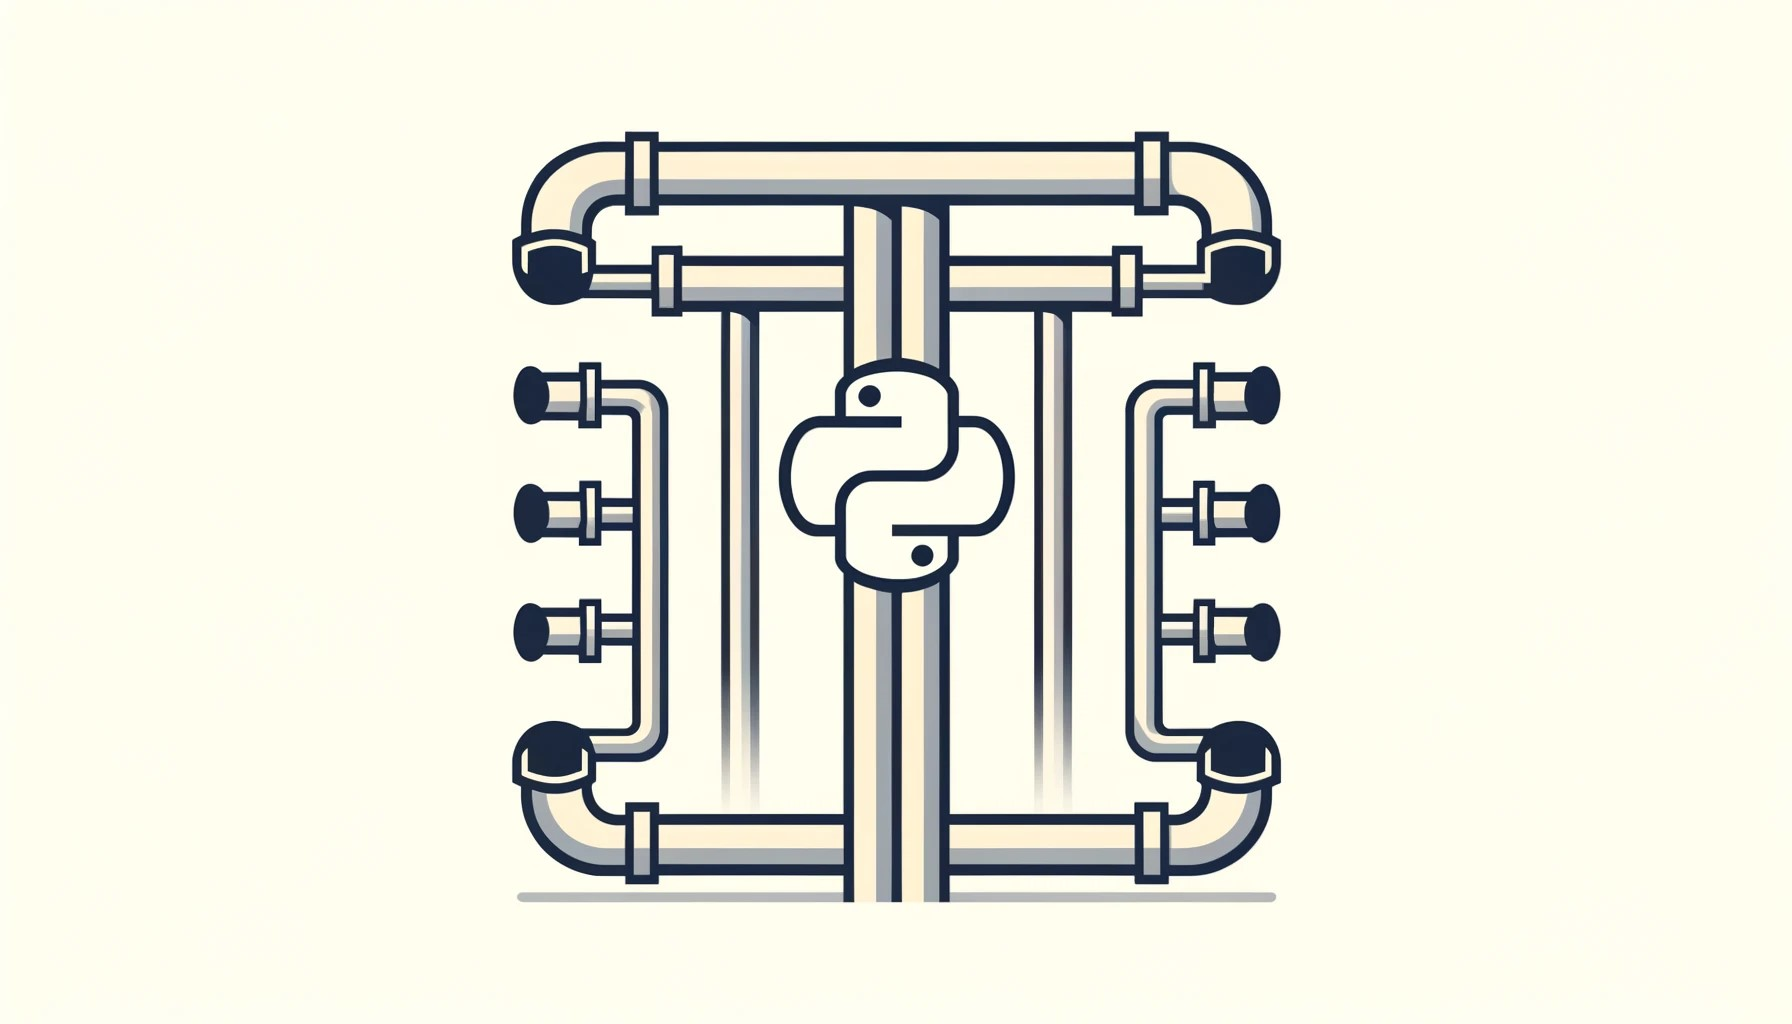

<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 1. Purpose🎉 </b></div>

**Pipeline allows you to call from preprocessing to model building like one module, which makes the process very clean, and it works well with GridSearch, which I often use for Kaggle projects.**

<div style="background-color:#f0fae9;padding:6px 10px;">
    <br>
    <div style="font-weight:bold;font-size:24px;">Content of This Notebook</div>
    <ul style="font-size:18px;">
      <li>Fundamental of Pipeline</li>
      <li>Incorporate your own functions into the pipe (FunctionTransformer)</li>
      <li>Branch the pipe (ColumnTransformer)</li>
      <li>Obtain various data in the pipes</li>
    </ul>
</div>

<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 2. Fundamental of Pipeline🔍</b></div>


### Use "Spaceship Titanic" data

In [ ]:
import pandas as pd
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df.dtypes

### Use Imputer because there are some missin values

In [ ]:
df.isnull().sum()

### In addition, One-Hot encoding is used since categorical variables are included.
### Also Choose `Decision tree Classifier' as the model.

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier 

target = 'Transported'
X = df.drop([target], axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = DecisionTreeClassifier(max_depth=4,random_state=1234)

# Pipeline From Here
simple_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False)),
        ('model', clf)
    ],
    verbose=True
)
simple_pipeline

## The pipe can be used as scikit-learn models

In [ ]:
simple_pipeline.fit(X_train,y_train)
print('='*30)
print('Prediction Result：', simple_pipeline.predict(X_test))
print('='*30)
print('Scores by Train Data：', simple_pipeline.score(X_train, y_train))
print('='*30)
print('Scores by Test Data：', simple_pipeline.score(X_test,y_test))

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 3. Incorporate Your Own Functions🔧</b></div>


**First, we have created a model, but there are some unnecessary variables that need to be removed. This is a simple drop() method, but we will <span style="color:red;">incorporate it into Pipeline as a function of our own creation</span>.
We will remove `PassengerID`, `Cabin`, and `Name` columns. (Cabin is a informative variable, but in this case we will remove it.)**

In [ ]:
# This is your own function
def processing1(dataframe):
    return dataframe.drop(['PassengerId','Cabin','Name'], axis=1)

### This can be transformed using `FunctionTransformer()` and incorporated into the Pipeline.

In [ ]:
from sklearn.preprocessing import FunctionTransformer
# Your Function
myfunc = FunctionTransformer(processing1)

clf = DecisionTreeClassifier(max_depth=4,random_state=1234)

myfunc_pipeline = Pipeline(
    steps=[
        ('dropcol', myfunc), # ←Here Is Yours
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False)),
        ('model', clf)
    ],
    verbose=True
)

myfunc_pipeline

In [ ]:
myfunc_pipeline.fit(X_train,y_train)
print('='*30)
print('Prediction Result：', myfunc_pipeline.predict(X_test))
print('='*30)
print('Scores by Train Data：', myfunc_pipeline.score(X_train, y_train))
print('='*30)
print('Scores by Test Data：', myfunc_pipeline.score(X_test,y_test))

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 4. Branch The Pipe👨‍🔧</b></div>




**Next, we encoded the <span style="color:red;">categorical variables</span> with the <span style="color:red;">One-Hot encoding</span>, but we do not do anything to the <span style="color:red;">numerical variables</span>, so we normalize them with the <span style="color:red;">MinMax method</span>. At this point, we want to change the process depending on the data type, so we branch the pipeline.**

### Use `ColumnTransformer()` to branch a Pipe.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

# Get The Names of Numerical Valuables
n_cols = df.loc[:,df.dtypes=='float'].columns
# Get The Names of Categorical Valuables
c_cols = df.loc[:,df.dtypes=='object'].columns

# Pipe Of The Numerical Valuable Root
num_pipeline = Pipeline(
    steps=[
        ('impute', SimpleImputer(strategy='mean')),
        ('scale',MinMaxScaler())
    ]
)

# Pipe Of The Categorical Valuable Root
cat_pipeline = Pipeline(
    steps=[
        ('drop', myfunc),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False))
    ],
    verbose=True
)

# Compose The Branch Structure
ct = ColumnTransformer(
    transformers=[
        ('num_pipeline',num_pipeline,np.array(n_cols)),
        ('cat_pipeline',cat_pipeline,np.array(c_cols))
    ],
remainder='drop',n_jobs=-1)

# Combine With The DT Model Pipe
clf = DecisionTreeClassifier(max_depth=4,random_state=1234)
parallel_pipeline = Pipeline(
    steps=[
        ('col_trans',ct),
        ('model', clf)
    ]
)

parallel_pipeline

In [ ]:
parallel_pipeline.fit(X_train,y_train)
print('='*30)
print('Prediction Result：', parallel_pipeline.predict(X_test))
print('='*30)
print('Scores by Train Data：', parallel_pipeline.score(X_train, y_train))
print('='*30)
print('Scores by Test Data：', parallel_pipeline.score(X_test,y_test))

<a id="5"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34); background-color:rgb(255,255,255); "> <b> 5. Obtain Various Data In The Pipe📂📁</b></div>

**As an example, try to draw trees with <span style="color:red;">graphviz</span>.
To do this, we get <span style="color:red;">the model</span> and <span style="color:red;">variable names</span> as arguments from the pipeline. For the variable names, we need to get ones after the One-Hot encoding(blue circle).
Then we get the numerical variables(red circle) and merge them.**

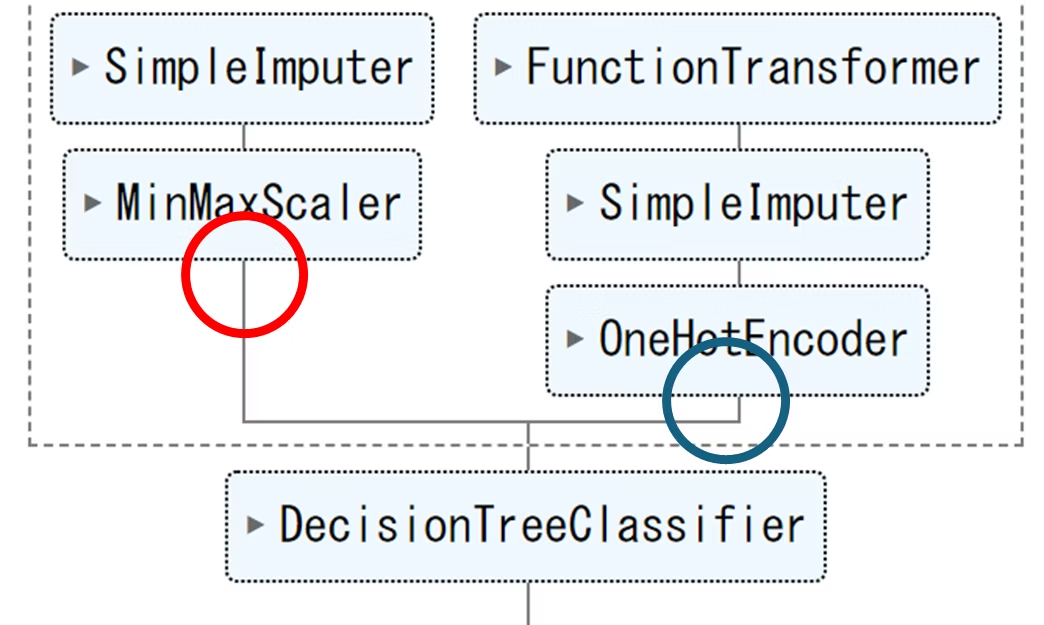

In [ ]:
# To Get The Model Is So Easy!
model = parallel_pipeline['model']

# Numerical Variable (Red Circle In The Figure). It is actually the same as df.dtypes=='float'.
n_cols_new = parallel_pipeline.named_steps['col_trans'].named_transformers_['num_pipeline'].get_feature_names_out()
print('Numerical:')
print(n_cols_new)

# Categorical Variable (Blue Circle In The Figure)
c_cols_new = parallel_pipeline.named_steps['col_trans'].named_transformers_['cat_pipeline'].named_steps['encoder'].get_feature_names_out()
print('Categorical:')
print(c_cols_new)

feature_names = list(n_cols_new) + list(c_cols_new)
print('All Valiables:')
print(feature_names)

### Use The Processed Variables As Feature Names

In [ ]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=feature_names,  
                                class_names=['True','False'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [ ]:
# If You Want The Image
# graph.render("decision_tree_graphivz")

### Also draw importance

In [ ]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
tree_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

### 😊Thank you for reading

Pipelines allow you to organize your processing, which improves the readability of your code. Also, once you get used to retrieving data in a pipe as described in this notebook, it will be easier to create graphs and other evaluations.
Also, although not introduced in this notebook, it can be incorporated into Gridsearch in this way.

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# gscv = GridSearchCV(PIPELINE, param, cv=10, refit=True, iid=False)

**Please follow my profiles!!**

[![Github](https://img.shields.io/badge/--FFFFFF?style=social&logo=github&label=Follow%20yutowac)](https://github.com/yutowac)


[![LinkedIn](https://img.shields.io/badge/--FFFFFF?style=social&logo=LinkedIn&label=Follow%20yutowac)](https://www.linkedin.com/in/wachi-yuto-b43ab3a2/)